In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, recall_score
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the data
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

In [7]:
# Data exploration and preprocessing
print("Original shape:", df.shape)
print("Missing values:\n", df.isnull().sum())

Original shape: (5110, 12)
Missing values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [8]:
# Feature engineering and improved preprocessing
# Handle missing values better - impute BMI instead of dropping
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [9]:
# Drop the ID column
df = df.drop(columns=['id'])

In [10]:
# Check for 'Other' in gender and handle it
if 'Other' in df['gender'].values:
    # Either combine with majority class or create a new category
    df = df[df['gender'] != 'Other']  # Removing for simplicity as these are typically few

In [11]:
# Convert 'ever_married' to binary
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})

In [12]:
# Create age groups that might be more predictive
df['age_group'] = pd.cut(df['age'], bins=[0, 18, 35, 50, 65, 100],
                labels=['Child', 'Young_Adult', 'Adult', 'Senior', 'Elderly'])

In [13]:
# Feature interaction: BMI × age might be important for stroke
df['bmi_age'] = df['bmi'] * df['age']

In [14]:
# Handling glucose levels - create categories
df['glucose_level'] = pd.qcut(df['avg_glucose_level'], q=4, labels=['Low', 'Medium', 'High', 'Very_High'])

In [15]:
# Better encoding
# One-hot encoding for categorical variables
cat_features = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'age_group', 'glucose_level']
df_encoded = pd.get_dummies(df, columns=cat_features, drop_first=True)


In [16]:
# Separate features and target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

In [17]:
# Print column names to verify encoding
print("\nFeatures after preprocessing:")
print(X.columns.tolist())
print(f"Total features: {X.shape[1]}")


Features after preprocessing:
['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'bmi_age', 'gender_Male', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes', 'age_group_Young_Adult', 'age_group_Adult', 'age_group_Senior', 'age_group_Elderly', 'glucose_level_Medium', 'glucose_level_High', 'glucose_level_Very_High']
Total features: 23


In [18]:
# Split data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))


Class distribution in training set:
stroke
0    0.951309
1    0.048691
Name: proportion, dtype: float64


In [19]:
# Function to evaluate and print model performance
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall_score(y_test, y_pred, pos_label=1)
    specificity = tn / (tn + fp)

    print(f"\n{model_name} Results:")
    print(f"Accuracy   : {round(acc * 100, 2)}%")
    print(f"Sensitivity (Recall for 1): {round(sensitivity * 100, 2)}%")
    print(f"Specificity (Recall for 0): {round(specificity * 100, 2)}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.show()

    return acc, sensitivity, specificity, roc_auc

In [20]:
# ---------- APPROACH 1: Advanced Logistic Regression with proper scaling ----------
# Create a pipeline with scaling and logistic regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', C=0.1))
])

In [21]:
# Train the model
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=1000))])


Logistic Regression with Scaling Results:
Accuracy   : 69.47%
Sensitivity (Recall for 1): 82.0%
Specificity (Recall for 0): 68.83%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       972
           1       0.12      0.82      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.69      0.78      1022



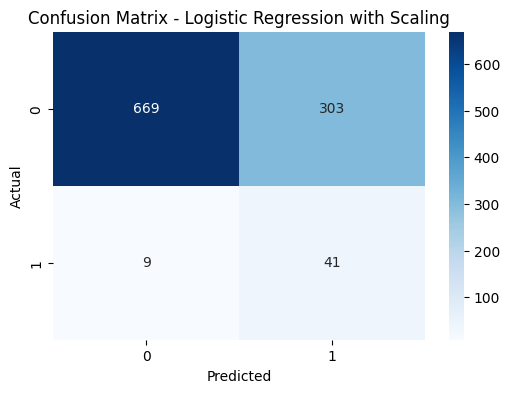

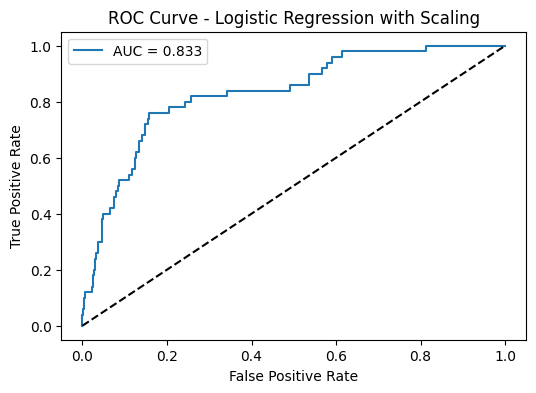

In [22]:
# Evaluate
lr_metrics = evaluate_model(pipe_lr, X_test, y_test, "Logistic Regression with Scaling")

In [23]:
# ---------- APPROACH 2: Using SMOTE to handle class imbalance ----------
# Create a pipeline with SMOTE
smote_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, C=0.1))
])

In [24]:
smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))])


Logistic Regression with SMOTE Results:
Accuracy   : 69.47%
Sensitivity (Recall for 1): 82.0%
Specificity (Recall for 0): 68.83%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       972
           1       0.12      0.82      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.75      0.51      1022
weighted avg       0.94      0.69      0.78      1022



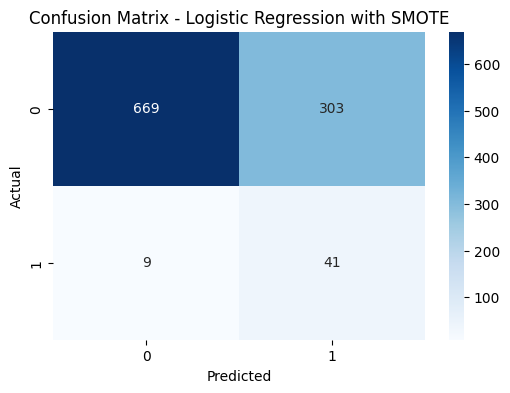

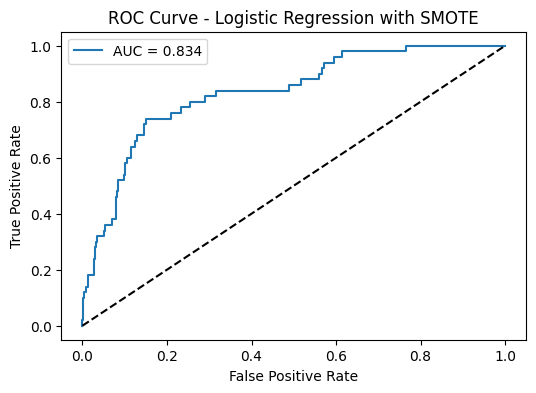

In [25]:
# Evaluate
smote_metrics = evaluate_model(smote_pipe, X_test, y_test, "Logistic Regression with SMOTE")

In [26]:
# ---------- APPROACH 3: Random Forest with hyperparameter tuning ----------
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [27]:
# Create RandomForest model
rf = RandomForestClassifier(random_state=42)

In [28]:
# Create grid search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='recall', n_jobs=-1)

In [29]:
# Train the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall')

In [30]:
# Get the best model
best_rf = grid_search.best_estimator_
print(f"\nBest RF Parameters: {grid_search.best_params_}")


Best RF Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}



Optimized Random Forest Results:
Accuracy   : 91.1%
Sensitivity (Recall for 1): 34.0%
Specificity (Recall for 0): 94.03%

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       972
           1       0.23      0.34      0.27        50

    accuracy                           0.91      1022
   macro avg       0.60      0.64      0.61      1022
weighted avg       0.93      0.91      0.92      1022



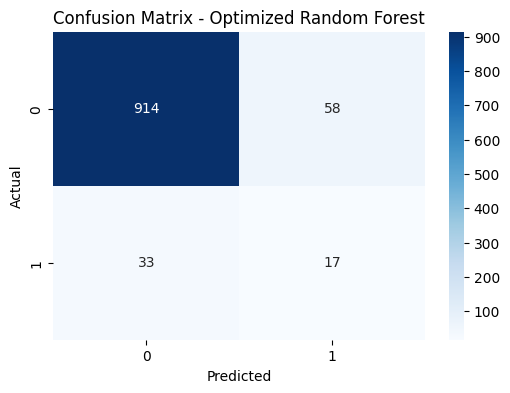

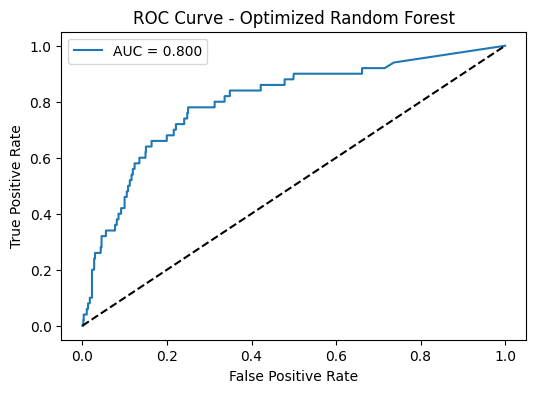

In [31]:
# Evaluate the best model
rf_metrics = evaluate_model(best_rf, X_test, y_test, "Optimized Random Forest")

In [32]:
# ---------- APPROACH 4: Gradient Boosting model ----------
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                               max_depth=3, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=42)


Gradient Boosting Results:
Accuracy   : 94.62%
Sensitivity (Recall for 1): 4.0%
Specificity (Recall for 0): 99.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.22      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.59      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022



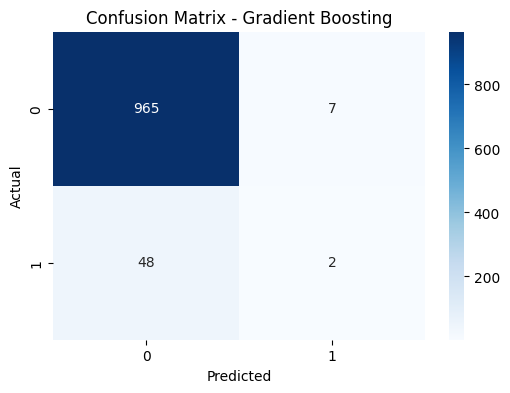

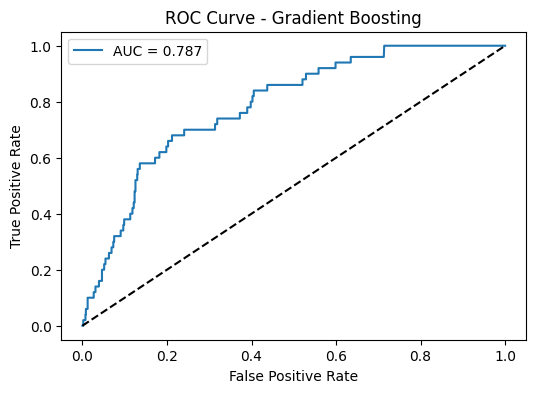

In [33]:
# Evaluate
gb_metrics = evaluate_model(gb, X_test, y_test, "Gradient Boosting")

In [34]:
# ---------- APPROACH 5: SVM with class weights and proper scaling ----------
svm_pipe = Pipeline([
    ('scaler', RobustScaler()),  # RobustScaler is good for datasets with outliers
    ('classifier', SVC(probability=True, class_weight='balanced', C=1.0, gamma='scale', kernel='rbf'))
])

In [35]:
# Train
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier', SVC(class_weight='balanced', probability=True))])


Support Vector Machine Results:
Accuracy   : 73.19%
Sensitivity (Recall for 1): 76.0%
Specificity (Recall for 0): 73.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       972
           1       0.13      0.76      0.22        50

    accuracy                           0.73      1022
   macro avg       0.56      0.75      0.53      1022
weighted avg       0.94      0.73      0.81      1022



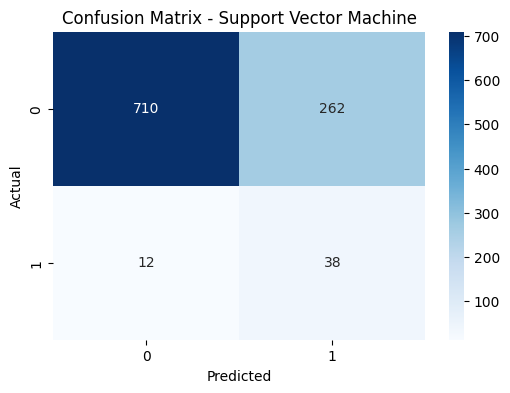

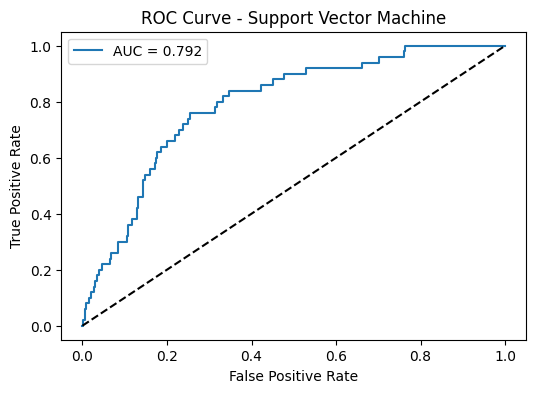

In [36]:
# Evaluate
svm_metrics = evaluate_model(svm_pipe, X_test, y_test, "Support Vector Machine")

In [37]:
# ---------- APPROACH 6: Ensemble of models (Voting) ----------
from sklearn.ensemble import VotingClassifier

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', pipe_lr),
        ('rf', best_rf),
        ('gb', gb),
        ('svm', svm_pipe)
    ],
    voting='soft'  # Use probability estimates for prediction
)

In [39]:
# Train
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(C=0.1,
                                                                  class_weight='balanced',
                                                                  max_iter=1000))])),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_split=5,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42)),
                             ('svm',
                              Pipeline(steps=[('scaler', RobustScaler()),
                                              ('classifier',
                                               SVC(class_weight='balanced',
                                                   probability=True))]))],
                 voting='soft')


Ensemble Model (Voting) Results:
Accuracy   : 94.52%
Sensitivity (Recall for 1): 10.0%
Specificity (Recall for 0): 98.87%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       972
           1       0.31      0.10      0.15        50

    accuracy                           0.95      1022
   macro avg       0.63      0.54      0.56      1022
weighted avg       0.92      0.95      0.93      1022



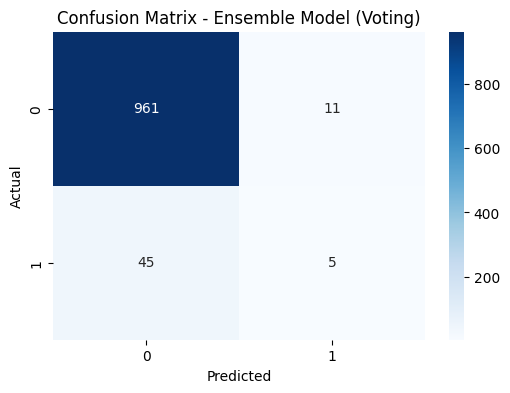

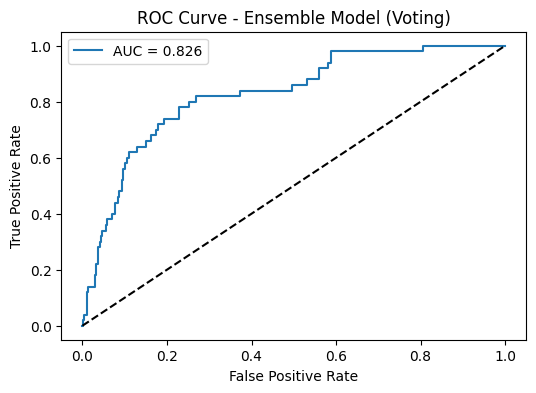

In [40]:
# Evaluate
ensemble_metrics = evaluate_model(voting_clf, X_test, y_test, "Ensemble Model (Voting)")

In [41]:
# Compare all models
models = ["Logistic Regression", "LR with SMOTE", "Random Forest", "Gradient Boosting", "SVM", "Ensemble"]
metrics = [lr_metrics, smote_metrics, rf_metrics, gb_metrics, svm_metrics, ensemble_metrics]

In [42]:
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': models,
    'Accuracy (%)': [round(m[0]*100, 2) for m in metrics],
    'Sensitivity (%)': [round(m[1]*100, 2) for m in metrics],
    'Specificity (%)': [round(m[2]*100, 2) for m in metrics],
    'AUC': [round(m[3], 3) for m in metrics]
})

print("\n--- Model Comparison ---")
print(comparison)


--- Model Comparison ---
                 Model  Accuracy (%)  Sensitivity (%)  Specificity (%)    AUC
0  Logistic Regression         69.47             82.0            68.83  0.833
1        LR with SMOTE         69.47             82.0            68.83  0.834
2        Random Forest         91.10             34.0            94.03  0.800
3    Gradient Boosting         94.62              4.0            99.28  0.787
4                  SVM         73.19             76.0            73.05  0.792
5             Ensemble         94.52             10.0            98.87  0.826


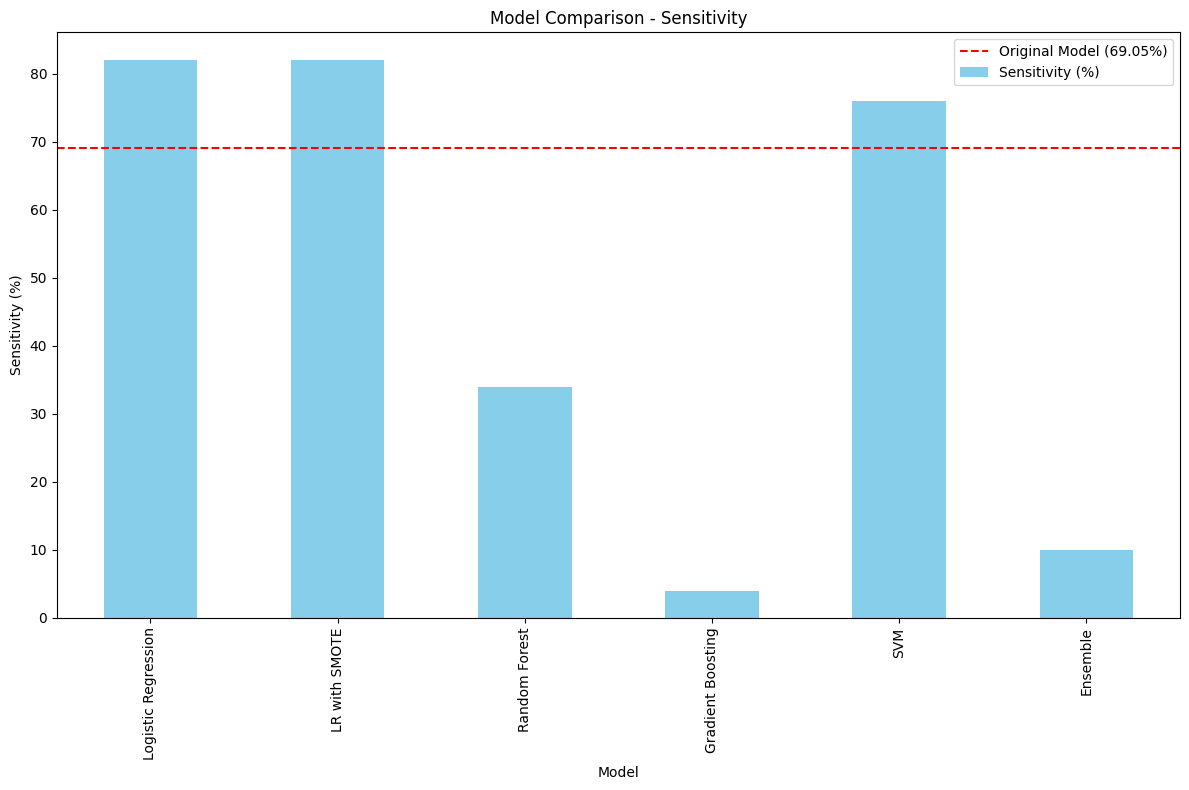

In [43]:
# Visualize model performance
plt.figure(figsize=(12, 8))
comparison.set_index('Model')['Sensitivity (%)'].plot(kind='bar', color='skyblue')
plt.axhline(y=69.05, color='r', linestyle='--', label='Original Model (69.05%)')
plt.ylabel('Sensitivity (%)')
plt.title('Model Comparison - Sensitivity')
plt.legend()
plt.tight_layout()
plt.show()

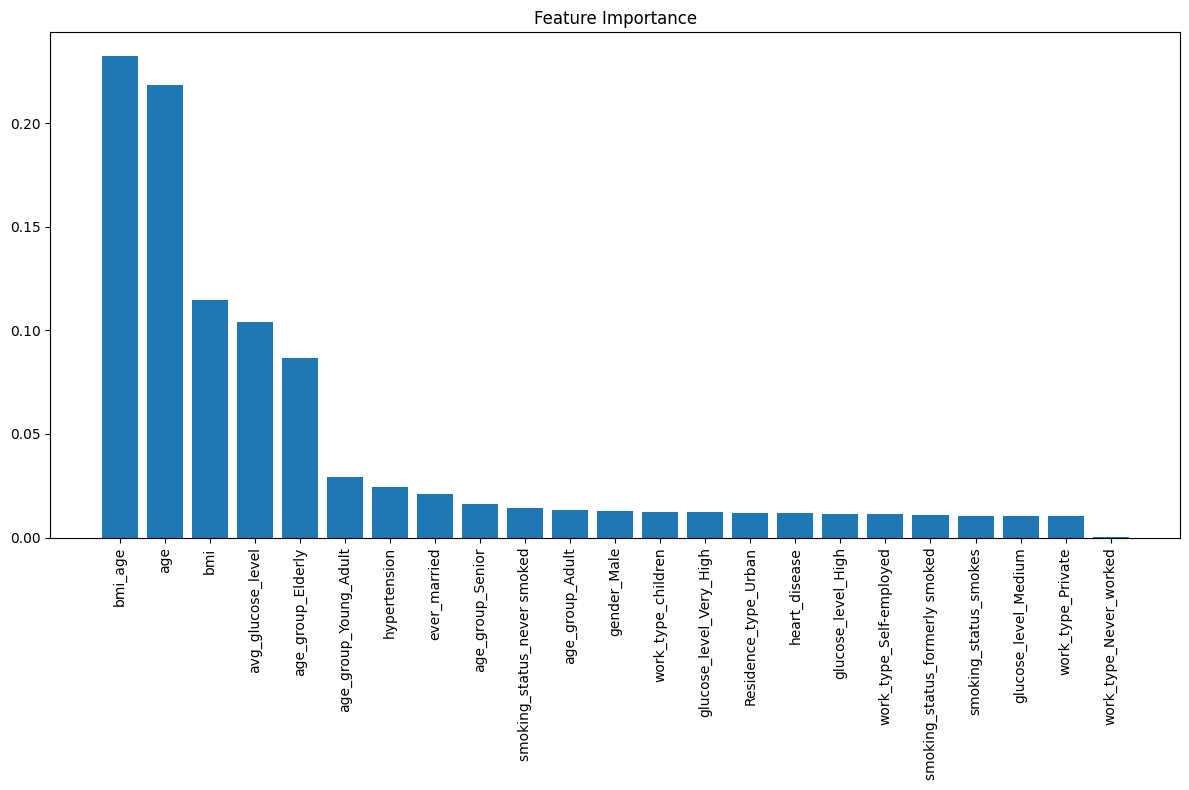


Top 10 Most Important Features:
1. bmi_age: 0.2323
2. age: 0.2183
3. bmi: 0.1145
4. avg_glucose_level: 0.1038
5. age_group_Elderly: 0.0865
6. age_group_Young_Adult: 0.0293
7. hypertension: 0.0242
8. ever_married: 0.0211
9. age_group_Senior: 0.0159
10. smoking_status_never smoked: 0.0145


In [44]:
# Feature importance from best model (if Random Forest or Gradient Boosting is best)
if 'feature_importances_' in dir(best_rf):
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 8))
    plt.title('Feature Importance')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    for i in range(min(10, X.shape[1])):
        print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")